<a href="https://colab.research.google.com/github/heisdenverr/MNIST/blob/master-branch/model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 4183 (delta 63), reused 109 (delta 41), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 20.41 MiB/s, done.
Resolving deltas: 100% (2434/2434), done.
Updating files: 100% (248/248), done.


In [3]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path /"pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} exists")
else:
  print(f"{image_path} not found")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading data")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping")
    zip_ref.extractall(image_path)

    os.remove(data_path / 'pizza_steak_sushi.zip')

data/pizza_steak_sushi not found
downloading data
Unzipping


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
BATCH_SIZE, NUM_WORKERS = 32, os.cpu_count()

In [61]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)

In [62]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [63]:
train_loader, test_loader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

In [64]:
img, label = next(iter(train_loader))

In [65]:
print(f"Image shape: {img.shape}")

Image shape: torch.Size([32, 3, 224, 224])


In [67]:
# Delete fc layer
modules = list(model.children())[:-1]
resnet = nn.Sequential(*modules)
# Set grad to false
for params in resnet.parameters():
  params.requires_grad = False

# Add last layer
resnet.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=len(class_names))
)
resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=3, bias=True)
)

In [68]:
summary(model=model,
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
results = engine.train(model=model,
                train_dataloader=train_loader,
                test_dataloader=test_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=100,
                device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9948 | train_acc: 0.4492 | test_loss: 0.9357 | test_acc: 0.4953
Epoch: 2 | train_loss: 0.8224 | train_acc: 0.6367 | test_loss: 0.4799 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.2513 | train_acc: 0.9258 | test_loss: 0.4286 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.2586 | train_acc: 0.9453 | test_loss: 0.3539 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.3254 | train_acc: 0.8477 | test_loss: 0.3447 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6447 | train_acc: 0.8203 | test_loss: 0.3697 | test_acc: 0.8362
Epoch: 7 | train_loss: 0.1165 | train_acc: 0.9766 | test_loss: 0.5797 | test_acc: 0.7633
Epoch: 8 | train_loss: 0.3361 | train_acc: 0.8086 | test_loss: 0.3266 | test_acc: 0.8674
Epoch: 9 | train_loss: 0.5894 | train_acc: 0.8125 | test_loss: 0.4575 | test_acc: 0.7538
Epoch: 10 | train_loss: 0.4726 | train_acc: 0.8008 | test_loss: 0.4264 | test_acc: 0.8655
Epoch: 11 | train_loss: 0.1771 | train_acc: 0.9648 | test_loss: 0.6424 | test_acc: 0.7036
Epoch: 12 | train_l

In [74]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

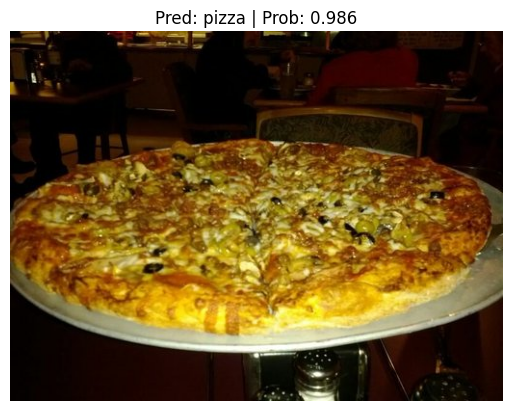

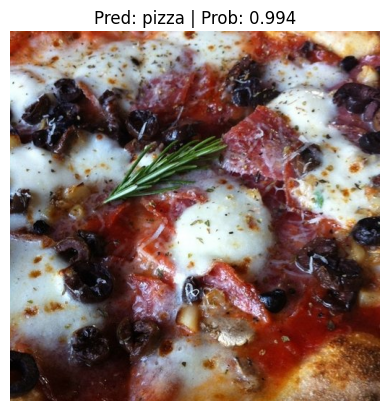

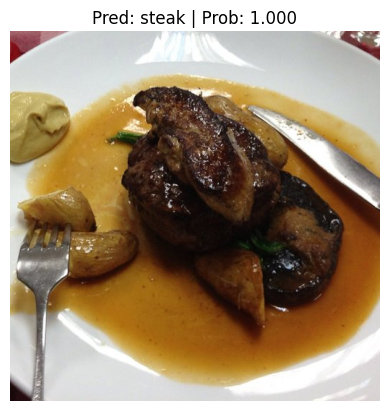

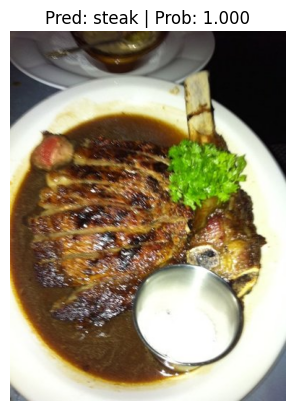

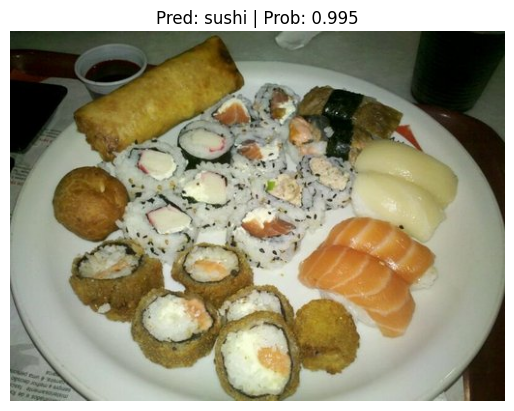

In [75]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

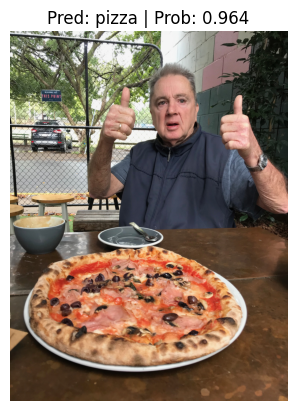

In [76]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)